# Datenvorverarbeitung

Dieses Notebook ist Teil des Projekts [EmbedML](https://hahn-schickard.de/projekte/embedml) und basiert auf den Inhalten des Kapitels [Datenvorverarbeitung](https://hahn-schickard.gitbook.io/embedml/2_ml/2.3_datenvorverarbeitung). Es ist auf [Colab](https://colab.research.google.com/drive/1S_7UrXVnOt4JJZNbiRcKLCKrHCzaTlLm?usp=sharing) und im [GitHub-Repository von Hahn-Schickard](https://github.com/Hahn-Schickard/EmbedML/blob/master/src/Datenvorverarbeitung.ipynb) zu finden.

Installation der benötigten Bibliotheken in den angegebenen Versionen.

In [1]:
!pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.0 seaborn==0.13.2 scipy==1.13.1 tensorflow==2.17.1 scikit-image==0.24.0 scikit-learn==1.5.2 imbalanced-learn==0.12.4 > /dev/null 2>&1

Das System kann den angegebenen Pfad nicht finden.


Laden der notwendigen Bibliotheken für die Datenbereinigung.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy import stats
from skimage import data
from sklearn import datasets
from sklearn.datasets import make_classification
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

## Datenbereinigung

Die Funktion `noisy_iris_dataset` fügt dem Iris-Datensatz Rauschen (Duplikate, fehlende Werte, Ausreißer) hinzu, um die Schritte der Datenbereinigung zu verdeutlichen. Die Funktionen `drop_missing_rows`, `impute_missing_mean`, und `interpolate_missing` zeigen verschiedene Ansätze zur Bereinigung der fehlenden Werte durch: Zeilen löschen, Mittelwert-Imputation und Interpolation.

In [3]:
def noisy_iris_dataset(iris_df, columns_with_noise):
    np.random.seed(42)

    # Einführen von Duplikaten
    df_noisy = pd.concat([iris_df, iris_df.sample(frac=0.15)])

    # Einführen von fehlenden Werten
    for _ in range(int(len(df_noisy) * 0.15)):
        row_idx = np.random.randint(0, len(df_noisy))
        col_idx = np.random.randint(0, len(df_noisy.columns))
        df_noisy.iat[row_idx, col_idx] = np.nan

    df_noisy.reset_index(drop=True, inplace=True)

    # Anzahl der Ausreißer, die eingefügt werden sollen
    num_outliers = int(len(df_noisy) * 0.15)
    max_dict = {col_name: df_noisy[col_name].max() for col_name in columns_with_noise}

    # Einführen von Ausreißern
    for _ in range(num_outliers):
        row_idx = np.random.randint(0, len(df_noisy))
        col_name = np.random.choice(columns_with_noise)
        multiplier = np.random.uniform(2, 3)
        df_noisy.loc[row_idx, col_name] = round(max_dict[col_name] * multiplier, 1)

    return df_noisy

# Funktion zum Entfernen von Zeilen mit fehlenden Werten
def drop_missing_rows(df):
    df.dropna(how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Funktion zum Umgang mit fehlenden Werten durch Imputation (mittels Mittelwert)
def impute_missing_mean(df):
    return df.fillna(round(df.mean(), 1))

# Funktion zum Interpolieren fehlender Werte
def interpolate_missing(df):
    return df.interpolate()

Dieser Code lädt den Iris-Datensatz aus scikit-learn, erstellt daraus ein Pandas DataFrame, fügt die Zielspalte hinzu, legt fest, welche Spalten Rauschen erhalten sollen, und gibt das DataFrame aus.

In [4]:
# Laden des Iris-Datensatzes aus scikit-learn
iris = datasets.load_iris()

# Erstellen eines Pandas DataFrame aus dem Iris-Datensatz
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Hinzufügen der Zielspalte
iris_df['target'] = iris.target

# Festlegen der Spalten, die Rauschen erhalten sollen
columns_with_noise = list(iris_df.columns)

# Ausgabe des DataFrames
print(iris_df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  

Der Befehl `df = noisy_iris_dataset(iris_df, columns_with_noise)` erstellt einen neuen DataFrame `df`, indem er dem bestehenden `iris_df` DataFrame Rauschen in den angegebenen Spalten (`columns_with_noise`) hinzufügt.

In [5]:
df = noisy_iris_dataset(iris_df, columns_with_noise)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,NaN,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
167,5.6,2.5,3.9,1.1,1.0
168,5.7,2.8,4.5,1.3,1.0
169,6.4,2.8,5.6,2.2,2.0
170,4.7,3.2,1.6,0.2,0.0


Der folgende Code visualisiert den Boxplot der Daten mit Ausreißern.

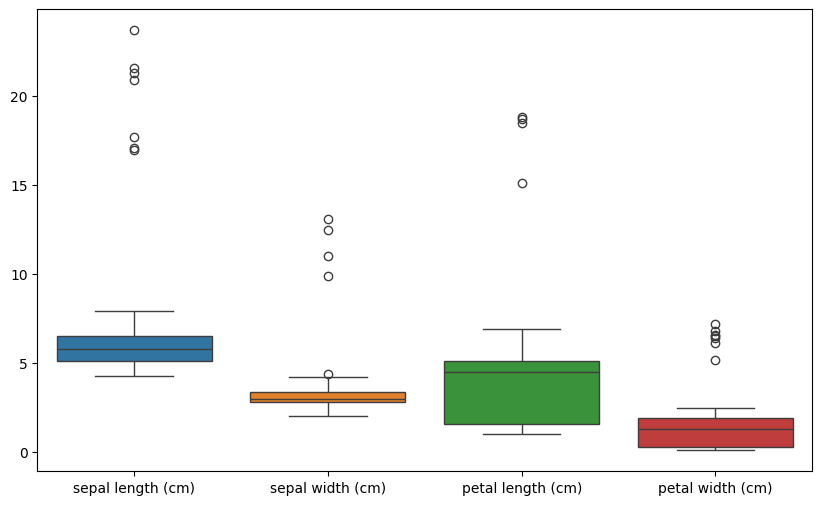

In [6]:
# Visualisierung des Boxplots der Daten ohne die Zielspalte
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop('target', axis=1))
plt.show()

Der Befehl entfernt Duplikate aus dem DataFrame `df`, sodass jede Zeile einzigartig ist.

In [7]:
df = df.drop_duplicates()

Fehlende Werte (NaN) werden entfernt oder aufgefüllt, da sonst alle Einträge in den z-Scores NaN wären. Anstelle des Entfernens der NaN-Werte (`df = df.dropna()`) werden diese mit dem Durchschnitt der jeweiligen Spalten aufgefüllt (`df = df.fillna(df.mean())`).

In [8]:
# df = df.dropna()
df = df.fillna(df.mean())

Mit dem folgenden Code werden Ausreißer mithilfe der Z-Score-Methode entfernt: Die Z-Scores für jede Spalte im DataFrame (ohne die Zielspalte) werden im ersten Schritt berechnet und anschließend ausgegeben.

Ein Z-Score ist ein statistischer Wert, der angibt, wie viele Standardabweichungen ein Datenpunkt vom Mittelwert entfernt ist; Werte mit extrem hohen oder niedrigen Z-Scores gelten als Ausreißer, weil sie weit außerhalb des typischen Bereichs der Datenverteilung liegen.

In [9]:
z_scores = stats.zscore(df.iloc[:, :-1])
z_scores

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.441173,0.157924,-0.979082,-0.953202
1,-0.506726,-0.191505,-0.979082,-0.953202
2,-0.572279,-0.051734,0.000000,-0.953202
3,-0.605055,-0.121619,-0.943322,-0.953202
4,-0.473949,0.227810,-0.979082,-0.953202
...,...,...,...,...
163,-0.506726,-0.121619,5.207435,-1.029966
165,-0.047854,0.018152,0.201005,3.882963
167,-0.277290,-0.540934,-0.085077,-0.262321
170,-0.572279,-0.051734,-0.907562,-0.953202


Die absoluten Z-Scores werden mit `np.abs()` berechnet und anschließend ausgegeben.

In [10]:
abs_z_scores = np.abs(z_scores)
print(abs_z_scores)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0             0.441173          0.157924           0.979082          0.953202
1             0.506726          0.191505           0.979082          0.953202
2             0.572279          0.051734           0.000000          0.953202
3             0.605055          0.121619           0.943322          0.953202
4             0.473949          0.227810           0.979082          0.953202
..                 ...               ...                ...               ...
163           0.506726          0.121619           5.207435          1.029966
165           0.047854          0.018152           0.201005          3.882963
167           0.277290          0.540934           0.085077          0.262321
170           0.572279          0.051734           0.907562          0.953202
171           0.113407          0.191505           0.000000          0.275031

[157 rows x 4 columns]


Es werden die Datenpunkte aus dem DataFrame gefiltert, deren absolute Z-Scores in allen Spalten kleiner als 3 Standardabweichungen vom Mittelwert liegen, bevor der gefilterte DataFrame ausgegeben wird.

In [11]:
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]
print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5           1.400000               0.2   
1                  4.9               3.0           1.400000               0.2   
2                  4.7               3.2           4.137908               0.2   
3                  4.6               3.1           1.500000               0.2   
4                  5.0               3.6           1.400000               0.2   
..                 ...               ...                ...               ...   
149                5.9               3.0           5.100000               1.8   
161                4.8               3.0           1.400000               0.1   
167                5.6               2.5           3.900000               1.1   
170                4.7               3.2           1.600000               0.2   
171                6.1               3.0           4.137908               1.8   

     target  
0       0.0  

Der folgende Code visualisiert den Boxplot der Daten ohne den Ausreißern, die einen Z-Score über 3 haben.

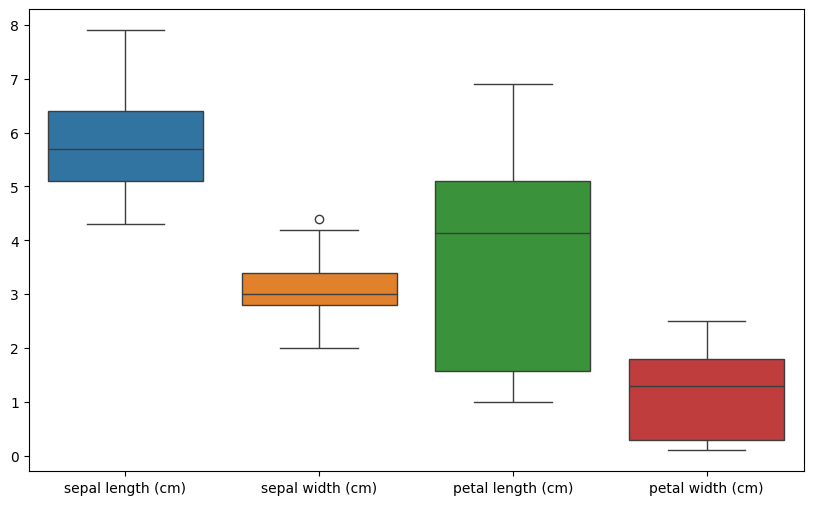

In [12]:
# Visualisierung des Boxplots der Daten ohne die Zielspalte
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop('target', axis=1))
plt.show()

Die Spaltennamen des DataFrames werden beispielhaft in Großbuchstaben umgewandelt, bevor sie ausgegeben werden. Ein Grund hierfür könnte sein um die Spaltennamen zu standardisieren und konsistenz zu gewährleisten.

In [13]:
df.columns = df.columns.str.upper()
df.columns

Index(['SEPAL LENGTH (CM)', 'SEPAL WIDTH (CM)', 'PETAL LENGTH (CM)',
       'PETAL WIDTH (CM)', 'TARGET'],
      dtype='object')

Die Spaltennamen des DataFrames werden beispielhaft in Kleinbuchstaben umgewandelt.

In [14]:
df.columns = df.columns.str.lower()
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

## Datenaugmentierung

Es wird ein ImageDataGenerator erstellt, der verschiedene Techniken zur Datenaugmentierung wie Rotation, Verschiebung in Breite und Höhe, Scherung, Zoom, horizontale Spiegelung und Füllmodus verwendet


 - `rotation_range`: Bereich für zufällige Rotationen der Bilder.
  - `width_shift_range`: Bereich für zufällige horizontale Verschiebungen der Bilder.
  - `height_shift_range`: Bereich für zufällige vertikale Verschiebungen der Bilder.
  - `shear_range`: Bereich für zufällige Scherungen der Bilder.
  - `zoom_range`: Bereich für zufällige Zooms der Bilder.
  - `horizontal_flip`: Zufällige horizontale Spiegelung der Bilder.
  - `fill_mode`: Strategie zur Füllung neu entstandener Pixel, die beim Verschieben oder Drehen der Bilder auftreten können.

In [15]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Ein Beispielbild wird von skimage geladen.

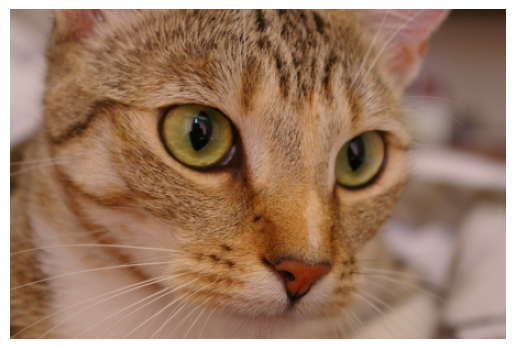

In [16]:
## Beispielbild (Katze) laden
img = data.chelsea()

plt.imshow(img)
plt.axis('off')
plt.show()

# Umwandlung in ein 4D-Array
img = np.expand_dims(img, axis=0)

Ein Zähler für die Bilder wird initialisiert, um über 4 augmentierte Bilder aus dem Generator zu iterieren, wobei für jedes Bild eine neue `plt.figure` erstellt wird.
Der Plot zeigt vier augmentierte Versionen des Bildes, die durch zufällige Transformationen wie Rotation, Verschiebung, Zoom und Spiegelung entstanden sind. Diese Augmentierungen erhöhen die Datenvielfalt und können einem ML-Modell helfen, robuster gegen Variationen im Bild zu werden, indem es zusätzliche, leicht veränderte Trainingsbeispiele erhält.

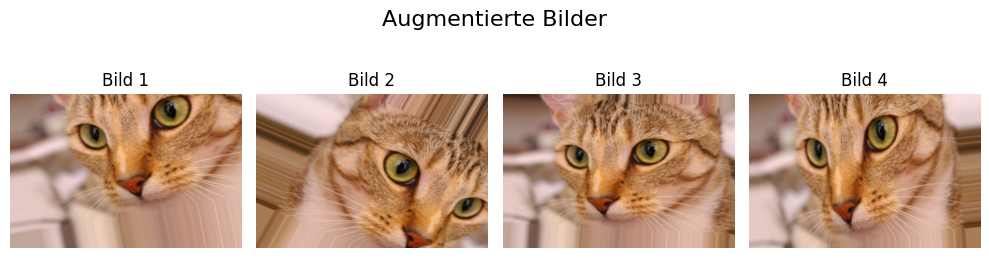

In [17]:
# Initialisierung eines Zählers für die Bilder
i = 0
# Iteration über die augmentierten Bilder aus dem Generator
for batch in datagen.flow(img, batch_size=1):
    # Erstellung einer neuen Figure für jedes Bild
    plt.figure(i // 4, figsize=(10, 3))  # Aufteilen in 4 Subplots
    plt.subplot(1, 4, i % 4 + 1)  # Position im Subplot festlegen

    # Anzeigen des augmentierten Bildes in der Figure
    imgplot = plt.imshow(array_to_img(batch[0]))

    # Anpassen von Titel und Achsenbeschriftungen
    plt.title(f'Bild {i + 1}')
    plt.axis('off')

    # Inkrementierung des Zählers für das nächste Bild
    i += 1
    # Wenn vier Bilder generiert wurden, die Schleife beenden
    if i % 4 == 0:
        break

# Anzeigen der generierten augmentierten Bilder
plt.suptitle('Augmentierte Bilder', fontsize=16)  # Haupttitel für die gesamte Figur
plt.tight_layout()  # Anpassen der Layouts für eine bessere Darstellung
plt.show()

## Datenexploration

Es wird ein Beispiel-Datensatz erstellt, bestehend aus 1000 Sampels mit 20 Merkmalen und 2 Klassen mit einem Gewichtsverhältnis von 0.1 zu 0.9 zwischen den Klassen.

In [18]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.1, 0.9], random_state=42)

Es wird `SMOTE` angewendet, eine Technik zur Datenaugmentierung, um das Ungleichgewicht zwischen den Klassen in den Merkmalsdaten `X` und der Zielvariablen `y` auszugleichen, unter Verwendung eines festgelegten Zufallsstartsatzes von 42.

In [19]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

Die resamplten Daten `X_res` und `y_res` werden in einen Pandas DataFrame `df_res` konvertiert, um eine bessere Übersichtlichkeit zu gewährleisten. Zusätzlich werden die Zielvariablen `y_res` als neue Spalte `'target'` im DataFrame hinzugefügt. Die Formen des ursprünglichen Datensatzes (`X.shape, y.shape`) sowie die des resampelten Datensatzes (`X_res.shape, y_res.shape`) werden ausgegeben.

Die neuen Daten haben eine abgewandelte Form, weil die SMOTE-Technik zur Datenaugmentierung zusätzliche Datenpunkte erzeugt, um das Ungleichgewicht zwischen den Klassen auszugleichen.

In [20]:
# Konvertierung der resamplten Merkmalsdaten X_res in einen Pandas DataFrame df_res
df_res = pd.DataFrame(X_res)

# Hinzufügen der Zielvariablen y_res als neue Spalte 'target' im DataFrame df_res
df_res['target'] = y_res

print('Original Dataset Shape:', X.shape, y.shape)
print('Resampled Dataset Shape:', X_res.shape, y_res.shape)

Original Dataset Shape: (1000, 20) (1000,)
Resampled Dataset Shape: (1790, 20) (1790,)
